## Transfer Learning CNN classifier with feature extraction using MobileNet 

### Reference Links used for code are as given below. 

1. For data pre-processing, splitting into training and validation datasets, feature extraction using a pre-trained CNN model : https://www.kaggle.com/orion99/transfer-learning-cnn?select=seg_test

2. For training a classifier on features extracted : https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/

3. Original code written for the CNN classifer for training and evaluation and plotting of the metrics

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
images_dir = 'dataset'
img_width, img_height = 128, 128
batch_size = 32

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPool2D
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam, Adamax
import warnings
warnings.filterwarnings("ignore")

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [7]:
train_gen = datagen.flow_from_directory(images_dir, target_size=(img_height, img_width), class_mode='categorical', batch_size=batch_size, subset='training')

Found 7213 images belonging to 16 classes.


In [8]:
test_gen = datagen.flow_from_directory(images_dir, target_size=(img_height, img_width), class_mode='categorical', batch_size=batch_size, subset='validation')

Found 1795 images belonging to 16 classes.


In [9]:
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='Max')

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
#Extract features for the training dataset

train_features = np.zeros(shape = (7213,4,4,1280))
train_labels = np.zeros(shape=(7213,16))

i = 0

for inputs_batch, labels_batch in train_gen:
  feature_batch = base_model.predict(inputs_batch)
  train_features[(i*batch_size):((i+1)*batch_size)] = feature_batch
  train_labels[(i*batch_size):((i+1)*batch_size)] = labels_batch
  i = i+1
  if (i*batch_size>=7213):
    break


In [12]:
print(train_features.shape)
print(train_labels.shape)

(7213, 4, 4, 1280)
(7213, 16)


In [13]:
#Extract features for the testing dataset

test_features = np.zeros(shape = (1795,4,4,1280))
test_labels = np.zeros(shape=(1795,16))

i = 0

for inputs_batch, labels_batch in test_gen:
  feature_batch = base_model.predict(inputs_batch)
  test_features[(i*batch_size):((i+1)*batch_size)] = feature_batch
  test_labels[(i*batch_size):((i+1)*batch_size)] = labels_batch
  i = i+1
  if (i*batch_size>=1795):
    break

In [14]:
print(test_features.shape)
print(test_labels.shape)

(1795, 4, 4, 1280)
(1795, 16)


In [36]:
#Building CNN model to train the features extracted

model = Sequential()

model.add(Flatten())
model.add(Dense(4096))
model.add(Dense(4096))
model.add(Dense(1000))
model.add(Dense(16, activation="softmax"))

model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])  
#model.summary()

In [37]:
hist = model.fit(train_features, train_labels, epochs=12, validation_data=(test_features, test_labels), verbose = 1)

Epoch 1/12
226/226 [==============================] - 166s 724ms/step - loss: 72.2433 - accuracy: 0.7019 - val_loss: 3.0364 - val_accuracy: 0.9565
Epoch 2/12
226/226 [==============================] - 165s 729ms/step - loss: 1.6036 - accuracy: 0.9692 - val_loss: 2.8415 - val_accuracy: 0.9510
Epoch 3/12
226/226 [==============================] - 163s 723ms/step - loss: 0.8549 - accuracy: 0.9764 - val_loss: 2.8824 - val_accuracy: 0.9499
Epoch 4/12
226/226 [==============================] - 164s 727ms/step - loss: 0.7133 - accuracy: 0.9768 - val_loss: 4.7260 - val_accuracy: 0.9315
Epoch 5/12
226/226 [==============================] - 163s 722ms/step - loss: 1.0796 - accuracy: 0.9709 - val_loss: 3.0921 - val_accuracy: 0.9621
Epoch 6/12
226/226 [==============================] - 167s 737ms/step - loss: 0.9856 - accuracy: 0.9764 - val_loss: 7.9877 - val_accuracy: 0.9109
Epoch 7/12
226/226 [==============================] - 162s 718ms/step - loss: 2.5583 - accuracy: 0.9557 - val_loss: 6.6340 

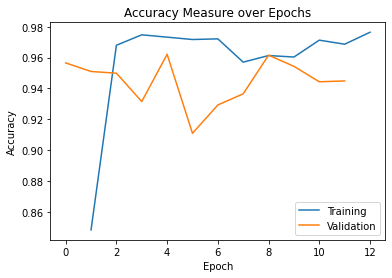

In [45]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,13)]
plt.plot(epochs, hist.history['accuracy'], hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy Measure over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

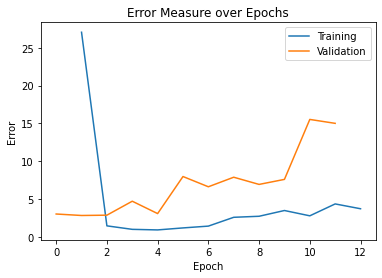

In [46]:
plt.plot(epochs, hist.history['loss'], hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Error Measure over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [50]:
test_labels_pred = model.predict(test_features)

y_test = np.argmax(test_labels, axis=1)
y_test_pred = np.argmax(test_labels_pred, axis=1)

In [54]:
classes = list(test_gen.class_indices.keys())

print("\n\nClassification Report on Testing Data:\n\n",classification_report(y_test, y_test_pred, target_names=classes))

print("\n\nAccuracy Score on Testing Data: ", accuracy_score(y_test, y_test_pred))



Classification Report on Testing Data:

               precision    recall  f1-score   support

           0       0.99      0.88      0.93       119
           1       0.94      0.97      0.96       112
           2       0.95      0.87      0.91        86
           3       0.97      0.87      0.92       108
           4       0.93      0.99      0.96       105
           5       0.88      0.98      0.92        86
           6       0.95      0.97      0.96       116
           7       0.94      0.94      0.94       106
           8       0.94      0.98      0.96       110
           9       0.95      0.97      0.96       109
         add       0.97      0.96      0.97       119
         dec       1.00      1.00      1.00       124
         div       0.98      0.98      0.98       123
          eq       0.79      1.00      0.88       126
         mul       0.99      0.99      0.99       115
         sub       1.00      0.76      0.87       131

    accuracy                         

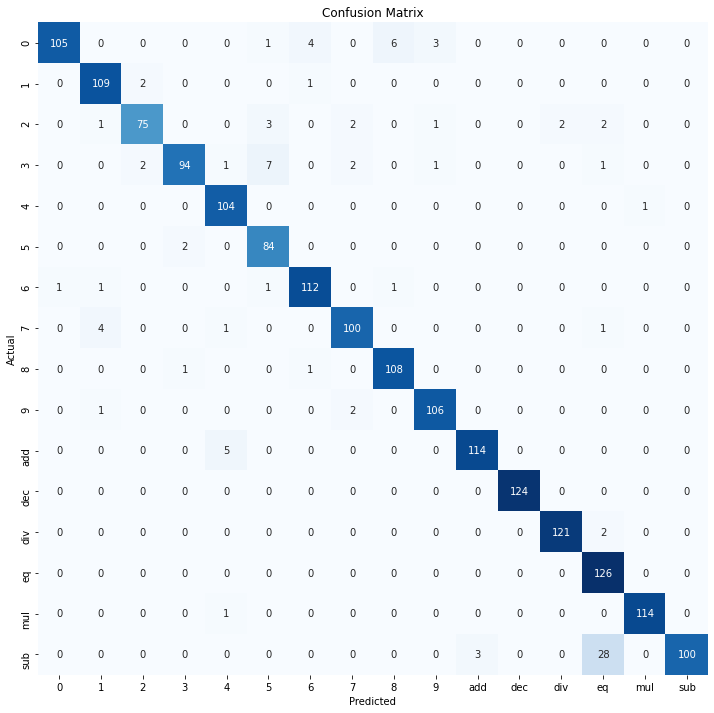

In [55]:

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, xticklabels = classes , yticklabels = classes, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()